# Gráficas para estudio de reservas en Guatemala

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import datetime
import matplotlib.dates as mdates
import locale

In [2]:
reservas = pd.read_excel("db/datos_reservas.xlsx")

In [3]:
reservas

,Mes,2018,2019,2020,2021,2022,2023,2024
0,Enero,23583.6,22534.9,25004.7,28095.1,30942.2,36777.0,39072.4
1,Febrero,23231.1,24279.6,22833.8,29303.8,31668.0,37656.0,39171.0
2,Marzo,23394.5,23921.7,26790.2,31923.8,33728.4,34766.3,NaN
3,Abril,22069.4,23513.2,28703.3,26911.7,30956.3,34766.3,NaN
4,Mayo,22381.8,24414.8,22167.7,30746.3,32612.2,37480.9,NaN
5,Junio,22871.6,24413.0,25497.2,34148.4,36370.1,40189.6,NaN
6,Julio,20389.7,26429.6,25330.4,27826.9,34156.6,37355.8,NaN
7,Agosto,22894.1,24245.4,25994.5,30667.9,33732.9,36738.0,NaN
8,Septiembre,23767.9,24682.2,31699.1,32638.9,34369.5,33770.6,NaN
9,Octubre,23591.0,25821.8,25824.7,28990.0,35388.7,34419.0,NaN


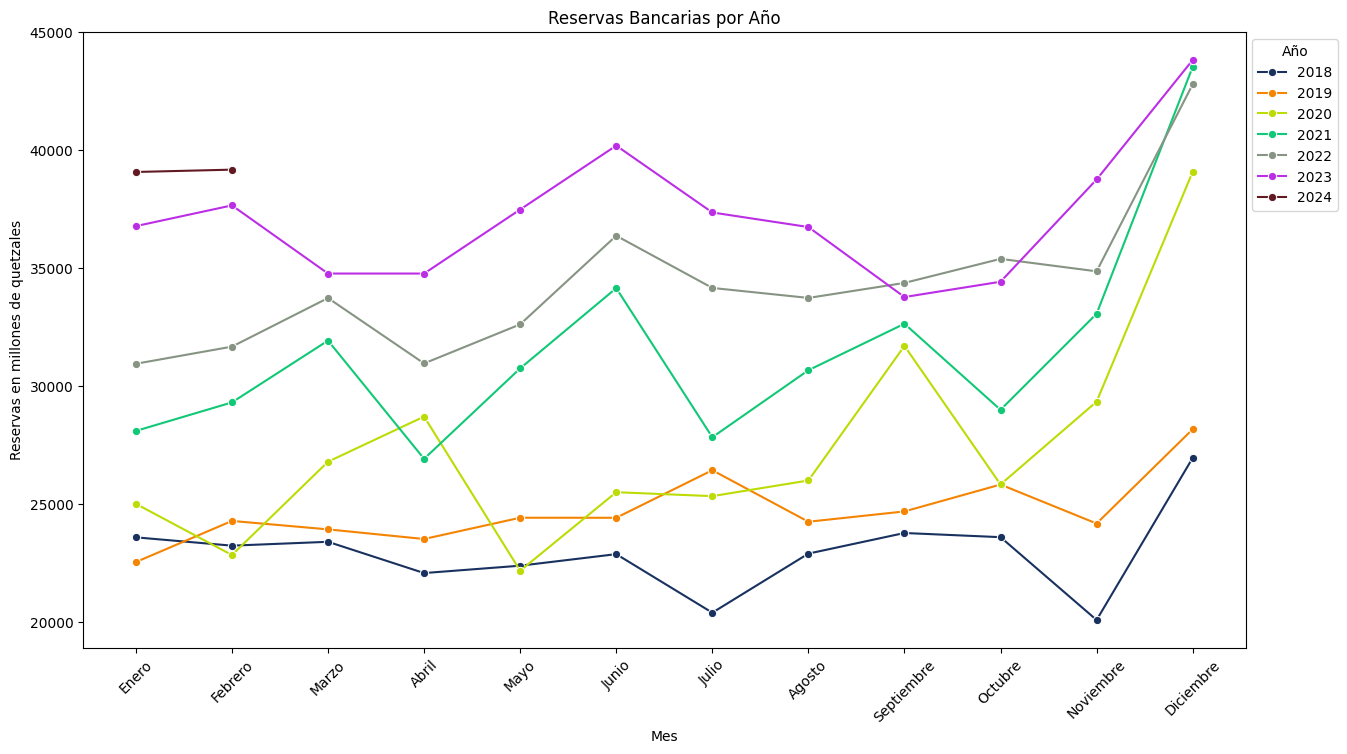

In [4]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=reservas.melt('Mes', var_name='Año', value_name='Reservas'), x='Mes', y='Reservas', hue='Año', marker='o', palette=["#19315F", "#F48401", "#BDDB05", "#11C876", "#879484", "#BC2EE6", "#621A22"])

plt.xticks(rotation=45)
plt.title('Reservas Bancarias por Año')
plt.xlabel('Mes')
plt.ylabel('Reservas en millones de quetzales')

# Mueve la leyenda fuera del gráfico, a la parte superior derecha
plt.legend(title='Año', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

## Calcular variaciones intermensuales e interanuales

In [5]:
# Variaciones intermensuales
int_mensuales = reservas[[i for i in range(2018, 2024)]].diff().fillna(0)
int_mensuales

,2018,2019,2020,2021,2022,2023
0,0.0,0.0,0.0,0.0,0.0,0.0
1,-352.5,1744.7,-2170.9,1208.7,725.8,879.0
2,163.4,-357.9,3956.4,2620.0,2060.4,-2889.7
3,-1325.1,-408.5,1913.1,-5012.1,-2772.1,0.0
4,312.4,901.6,-6535.6,3834.6,1655.9,2714.6
5,489.8,-1.8,3329.5,3402.1,3757.9,2708.7
6,-2481.9,2016.6,-166.8,-6321.5,-2213.5,-2833.8
7,2504.4,-2184.2,664.1,2841.0,-423.7,-617.8
8,873.8,436.8,5704.6,1971.0,636.6,-2967.4
9,-176.9,1139.6,-5874.4,-3648.9,1019.2,648.4


In [6]:
# Hacer diccionario con estadísticos por año
est_anuales = {i: [0,0,0,0] for i in range(2018,2024)}
for i in range(2018, 2024):
    est_anuales[i][0] = reservas[i].mean()
    est_anuales[i][1] = reservas[i].var()
    est_anuales[i][2] = reservas[i].min()
    est_anuales[i][3] = reservas[i].max()

df_est_anuales = pd.DataFrame.from_dict(est_anuales, orient="index", columns=["Promedio", "Varianza", "Mínimo", "Máximo"])
df_est_anuales.index.name = "Año"

df_est_anuales

,Promedio,Varianza,Mínimo,Máximo
Año,,,,
2018,22933.891667,3.060820e+06,20080.1,26951.9
2019,24716.083333,2.163543e+06,22534.9,28167.2
2020,27355.208333,2.063981e+07,22167.7,39080.5
2021,31486.908333,1.946687e+07,26911.7,43528.6
2022,34297.850000,1.006755e+07,30942.2,42788.4
2023,37207.750000,7.928795e+06,33770.6,43819.8


## Análisis de reservas e inflación

In [7]:
reservas_iniciales_anuales = reservas[reservas["Mes"] == "Enero"]
ritmo_inflacionario = pd.read_excel("db/Ritmo_inflacionario.xlsx")

In [8]:
ritmo_inflacionario

,Año,2018,2019,2020,2021,2022,2023,2024
0,Enero,-0.395434,1.349085,-0.239774,0.154736,-0.039164,0.376457,0.03
1,Febrero,-0.202247,0.136710,-0.402941,0.315712,0.424448,0.636981,0.14
2,Marzo,0.232680,-0.043113,0.482646,0.334806,1.495546,0.378586,NaN
3,Abril,0.044930,0.603839,0.713428,0.106781,0.538151,0.170900,NaN
4,Mayo,0.471557,0.264380,0.189367,0.160000,1.306315,-0.358866,NaN
5,Junio,0.573642,0.826682,1.407070,0.186368,1.830419,0.295212,NaN
6,Julio,0.355556,-0.056545,0.421096,0.332182,1.080981,0.700536,NaN
7,Agosto,0.442870,-0.862801,0.398708,0.205271,0.684429,0.625512,NaN
8,Septiembre,0.595238,-0.584962,0.157480,0.211458,0.358097,0.563528,NaN
9,Octubre,0.336036,0.696039,1.059612,0.362677,0.979740,1.265165,NaN


In [9]:
dic_proyeccion = {i: [None]*12 for i in range(2018, 2024)}
dic_proyeccion["Mes"] = ritmo_inflacionario["Año"].tolist()
df_proyeccion = pd.DataFrame.from_dict(dic_proyeccion)
df_proyeccion = df_proyeccion[["Mes", 2018, 2019, 2020, 2021, 2022, 2023]]

In [10]:
for i in range(2018, 2024):
    for j in range(0, 12):
        if j == 0:
            df_proyeccion.loc[0, i] = reservas.loc[0, i]
        else:
           df_proyeccion.loc[j, i] = df_proyeccion.loc[j-1, i] * (1 + ritmo_inflacionario.loc[j-1,i] / 100)

In [11]:
df_proyeccion

,Mes,2018,2019,2020,2021,2022,2023
0,Enero,23583.6,22534.9,25004.7,28095.1,30942.2,36777.0
1,Febrero,23490.342461,22838.914913,24944.745148,28138.573311,30930.081645,36915.449417
2,Marzo,23442.833903,22870.138066,24844.232602,28227.410078,31061.363825,37150.593666
3,Abril,23497.380766,22860.278123,24964.142306,28321.917277,31525.90077,37291.240693
4,Mayo,23507.938223,22998.317327,25142.243484,28352.15958,31695.557742,37354.971377
5,Junio,23618.791524,23059.120309,25189.85469,28397.523036,32109.60154,37220.91718
6,Julio,23754.278893,23249.745876,25544.293667,28450.447067,32697.341762,37330.79767
7,Agosto,23838.738551,23236.599285,25651.859725,28544.954265,33050.793786,37592.313236
8,Septiembre,23944.313124,23036.113775,25754.135649,28603.548728,33277.003081,37827.457484
9,Octubre,24086.838797,22901.361219,25794.693343,28664.033336,33396.166906,38040.625635


In [12]:
# Combinar dfs para poder graficar
df_combinado = reservas.join(df_proyeccion, lsuffix="_re", rsuffix="_pro")
plt.figure(figsize=(10, 12))

for year in range(2018, 2024):  # Asumiendo que tienes datos de 2018 a 2023.
    plt.figure(figsize=(10, 5))  # Crea una nueva figura para cada año.
    plt.plot(df_combinado["Mes_re"], df_combinado[str(year) + '_re'], marker='o', label='Reservas reportadas', color="#FF0000")
    plt.plot(df_combinado["Mes_re"], df_combinado[str(year) + '_pro'], marker='o', linestyle='--', label='Proyección con ritmo inflacionario', color="#0000ff")
    
    plt.title(f'Reservas Bancarias - {year}')
    plt.xlabel('Mes')
    plt.xticks(rotation=25)
    plt.ylabel('Reservas en millones de quetzales')
    plt.legend()
    plt.grid(True)
    
    # Guarda la figura en un archivo.
    # Reemplaza 'ruta/del/directorio' con la ruta real donde deseas guardar los archivos.
    plt.savefig(f'imagenes/reservas_{year}.png', bbox_inches="tight")
    plt.close()  # Cierra la figura para evitar el sobreplotting.

<Figure size 1000x1200 with 0 Axes>

## Segundo Análsis de inflación

In [13]:
dic_retro = {i: [None]*12 for i in range(2018, 2024)}
dic_retro["Mes"] = ritmo_inflacionario["Año"].tolist()
df_retro = pd.DataFrame.from_dict(dic_proyeccion)
df_retro = df_retro[["Mes", 2018, 2019, 2020, 2021, 2022, 2023]]

In [14]:
for i in range(2018, 2024):
    for j in range(0, 12):
        if j == 0:
            df_retro.loc[0, i] = reservas.loc[0, i]
        else:
           df_retro.loc[j, i] = df_retro.loc[j-1, i] * (1 - ritmo_inflacionario.loc[j-1,i] / 100)
            

In [15]:
df_retro

,Mes,2018,2019,2020,2021,2022,2023
0,Enero,23583.6,22534.9,25004.7,28095.1,30942.2,36777.0
1,Febrero,23676.857539,22230.885087,25064.654852,28051.626689,30954.318355,36638.550583
2,Marzo,23724.743319,22200.493173,25165.650563,27963.064423,30822.933303,36405.170126
3,Abril,23669.540508,22210.064414,25044.189548,27869.44227,30361.962195,36267.345169
4,Mayo,23658.905699,22075.951453,24865.517291,27839.683122,30198.568972,36205.364321
5,Junio,23547.3405,22017.587022,24818.430114,27795.139629,29804.080561,36335.292973
6,Julio,23412.263005,21835.571622,24469.217342,27743.338251,29258.541031,36228.026949
7,Agosto,23329.019403,21847.918567,24366.17839,27651.179939,28942.261787,35974.236686
8,Septiembre,23225.702222,22036.422532,24269.028576,27594.420134,28744.172486,35749.213692
9,Octubre,23087.453995,22165.327272,24230.809633,27536.069414,28641.240574,35547.757018


In [16]:
# Combinar dfs para poder graficar
df_combinado_2 = reservas.join(df_retro, lsuffix="_re", rsuffix="_retro")
plt.figure(figsize=(10, 12))

for year in range(2018, 2024):  # Asumiendo que tienes datos de 2018 a 2023.
    plt.figure(figsize=(10, 5))  # Crea una nueva figura para cada año.
    plt.plot(df_combinado_2["Mes_re"], df_combinado_2[str(year) + '_re'], marker='o', label='Reservas reportadas', color="#FF0000")
    plt.plot(df_combinado_2["Mes_re"], df_combinado_2[str(year) + '_retro'], marker='o', linestyle='--', label='Proyección sin ritmo inflacionario', color="#0000ff")
    
    plt.title(f'Reservas Bancarias - {year}')
    plt.xlabel('Mes')
    plt.xticks(rotation=25)
    plt.ylabel('Reservas en millones de quetzales')
    plt.legend()
    plt.grid(True)
    
    # Guarda la figura en un archivo.
    # Reemplaza 'ruta/del/directorio' con la ruta real donde deseas guardar los archivos.
    plt.savefig(f'imagenes/retro_{year}.png', bbox_inches="tight")
    plt.close()  # Cierra la figura para evitar el sobreplotting.

<Figure size 1000x1200 with 0 Axes>

## Modelo ARIMA

In [17]:
# Retomar los df de ritmo inflacionario y el de reservas para hacer arima
serie_inflacion = []
serie_inflacion_testeo = []
tiempo = []
tiempo_testeo = []

for i in range(2018, 2024):
    serie_inflacion += list(ritmo_inflacionario[i])

for i in range(2024, 2025):
    serie_inflacion_testeo += list(ritmo_inflacionario[i])

for i in range(2018, 2024):
    for j in range(1,10):
        tiempo.append(f"01/0{j}/{i}")
    for j in range(10, 13):
        tiempo.append(f"01/{j}/{i}")

for i in range(2024, 2025):
    for j in range(1,10):
        tiempo_testeo.append(f"01/0{j}/{i}")
    for j in range(10, 13):
        tiempo_testeo.append(f"01/{j}/{i}")

# Hacer df para arima con datos de inflacion 
dic_arima_inflacion = {"Tiempo": tiempo, "Inflación": serie_inflacion}
df_arima_inflacion = pd.DataFrame.from_dict(dic_arima_inflacion)
df_arima_inflacion["Tiempo"] = pd.to_datetime(df_arima_inflacion["Tiempo"])
df_arima_inflacion["Inflación"] = df_arima_inflacion["Inflación"].astype("float")
df_arima_inflacion.set_index("Tiempo", inplace=True)

# Hacer df de testeo
dic_arima_inflacion_testeo = {"Tiempo": tiempo_testeo, "Inflación": serie_inflacion_testeo}
df_arima_inflacion_testeo = pd.DataFrame.from_dict(dic_arima_inflacion_testeo)
df_arima_inflacion_testeo["Tiempo"] = pd.to_datetime(df_arima_inflacion_testeo["Tiempo"])
df_arima_inflacion_testeo["Inflación"] = df_arima_inflacion_testeo["Inflación"].astype("float")
df_arima_inflacion_testeo.set_index("Tiempo", inplace=True)

# Repetir para datos de reservas
serie_reservas = []
serie_reservas_testeo = []

for i in range(2018, 2024):
    serie_reservas += list(reservas[i])

for i in range(2024, 2025):
    serie_reservas_testeo += list(reservas[i])

# Hacer df para arima con datos de reservas 
dic_arima_reservas = {"Tiempo": tiempo, "Reservas": serie_reservas}
df_arima_reservas = pd.DataFrame.from_dict(dic_arima_reservas)
df_arima_reservas["Tiempo"] = pd.to_datetime(df_arima_reservas["Tiempo"])
df_arima_reservas["Reservas"] = df_arima_reservas["Reservas"].astype("float")
df_arima_reservas.set_index("Tiempo", inplace=True)


# Hacer df de testeo
dic_arima_reservas_testeo = {"Tiempo": tiempo_testeo, "Reservas": serie_reservas_testeo}
df_arima_reservas_testeo = pd.DataFrame.from_dict(dic_arima_reservas_testeo)
df_arima_reservas_testeo["Tiempo"] = pd.to_datetime(df_arima_reservas_testeo["Tiempo"])
df_arima_reservas_testeo["Reservas"] = df_arima_reservas_testeo["Reservas"].astype("float")
df_arima_reservas_testeo.set_index("Tiempo", inplace=True)

In [18]:
def hallar_parametros_arima(df, variables):
    modelo_var = {var : (0,0,0) for var in variables}
    for var in variables:
        modelo = auto_arima(df[var], max_p=100, max_d=5, max_q=100)
        modelo_var[var] = modelo.order
    return modelo_var

In [19]:
# Hallar parámetros para arima
parametros_inflacion = hallar_parametros_arima(df_arima_inflacion, ["Inflación"])["Inflación"]
parametros_reservas = hallar_parametros_arima(df_arima_reservas, ["Reservas"])["Reservas"]


# Aplicar ARIMA
modelo_inflacion = ARIMA(df_arima_inflacion, order=parametros_inflacion)
modelo_fit_inflacion = modelo_inflacion.fit()
predicciones_inflacion = modelo_fit_inflacion.forecast(steps=14)

modelo_reservas = ARIMA(df_arima_reservas, order=parametros_reservas)
modelo_fit_reservas = modelo_reservas.fit()
predicciones_reservas = modelo_fit_reservas.forecast(steps=14)

c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No suppor

In [20]:
# Aplicar SARIMA
model_sarima_inflacion = SARIMAX(df_arima_inflacion["Inflación"], order=parametros_inflacion, seasonal_order=(1,0,1,12))
modelo_fit__sarima_inflacion = model_sarima_inflacion.fit()

# Realizar predicciones
predicciones_sarima_inflacion = modelo_fit__sarima_inflacion.get_forecast(steps=12)
predicciones_sarima_inflacion = predicciones_sarima_inflacion.predicted_mean

# Ahora para reservas
model_sarima_reservas = SARIMAX(df_arima_reservas["Reservas"], order=parametros_reservas, seasonal_order=(1,0,2,12))
modelo_fit__sarima_reservas = model_sarima_reservas.fit()

# Realizar predicciones
predicciones_sarima_reservas = modelo_fit__sarima_reservas.get_forecast(steps=12)
predicciones_sarima_reservas = predicciones_sarima_reservas.predicted_mean

c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Mariajose\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is av

## Utilizar proyecciones para repetir gráficos del inicio

In [37]:
# Proyección de valor constante de inicio de año
dic_sarima_proyeccion = {"Tiempo": tiempo_testeo, "Reservas": predicciones_sarima_reservas, "Inflación": predicciones_sarima_inflacion}
df_sarima_proyecion = pd.DataFrame.from_dict(dic_sarima_proyeccion)
df_sarima_proyecion["Reservas constantes"] = None

for i in range(72, 84):
    if i == 72:
        df_sarima_proyecion.loc[i, "Reservas constantes"] = df_sarima_proyecion.loc[i, "Reservas"]
    else:
        df_sarima_proyecion.loc[i, "Reservas constantes"] = df_sarima_proyecion.loc[i-1, "Reservas constantes"] + (1 + df_sarima_proyecion.loc[i-1, "Inflación"]/100)

# Proyección de valor constante
df_sarima_proyecion["Reservas sin inflación"] = None 
for i in range(72, 84):
    if i == 72:
        df_sarima_proyecion.loc[i, "Reservas sin inflación"] = df_sarima_proyecion.loc[i,"Reservas"]
    else:
        df_sarima_proyecion.loc[i,"Reservas sin inflación"] = df_sarima_proyecion.loc[i, "Reservas"] * (1 - df_sarima_proyecion.loc[i-1, "Inflación"]/100)

df_sarima_proyecion = df_sarima_proyecion.loc[72:84]

## Gráficas para SARIMA

C:\Users\Mariajose\AppData\Local\Temp\ipykernel_10656\4082992410.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(month_labels, rotation=90)


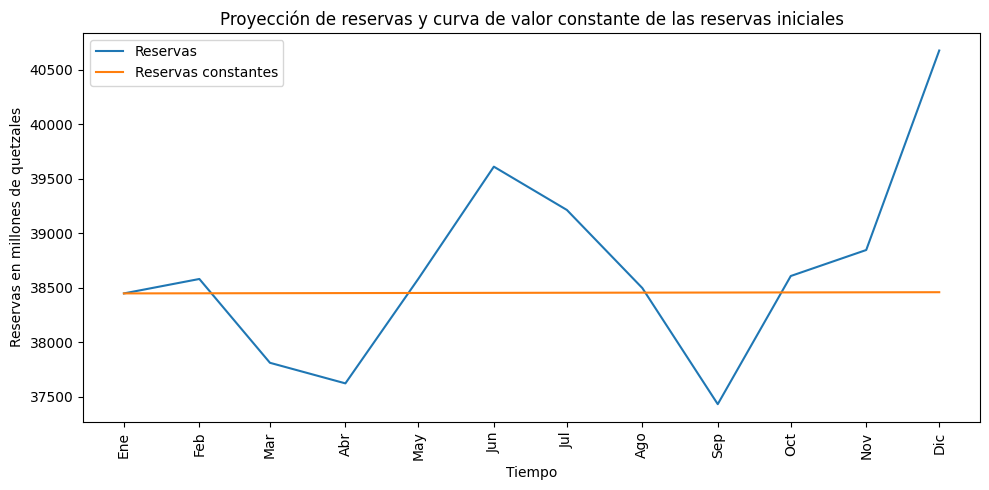

C:\Users\Mariajose\AppData\Local\Temp\ipykernel_10656\4082992410.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(month_labels, rotation=90)


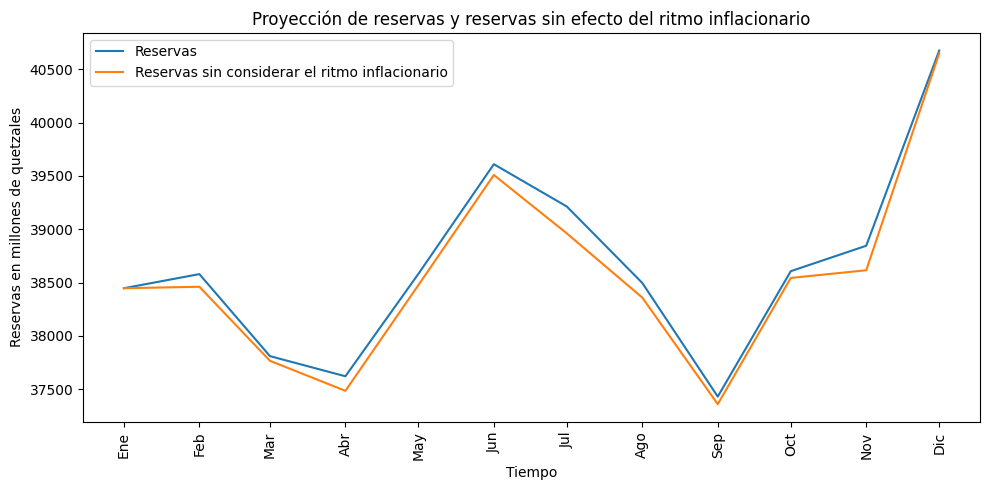

In [38]:
# Convert 'Tiempo' to datetime and set as index
try:
    df_sarima_proyecion['Tiempo'] = pd.to_datetime(df_sarima_proyecion['Tiempo'], format='%d/%m/%Y')
    df_sarima_proyecion.set_index('Tiempo', inplace=True)
except:
    pass

# Ensure the index is a DateTimeIndex
if not isinstance(df_sarima_proyecion.index, pd.DatetimeIndex):
    raise TypeError("The DataFrame index is not a DateTimeIndex. Make sure you have converted it correctly.")

# Spanish month names
spanish_months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Extract the unique months from the DataFrame index
unique_months = df_sarima_proyecion.index.month.unique()
month_labels = [spanish_months[month - 1] for month in sorted(unique_months)]

# Now create the plot, ensuring that the x-axis is formatted properly
plt.figure(figsize=(10, 5))
plt.plot(df_sarima_proyecion.index, df_sarima_proyecion['Reservas'], label='Reservas')
plt.plot(df_sarima_proyecion.index, df_sarima_proyecion['Reservas constantes'], label='Reservas constantes')
plt.title('Proyección de reservas y curva de valor constante de las reservas iniciales')
plt.xlabel('Tiempo')
plt.ylabel('Reservas en millones de quetzales')

# Create a locator for every unique month and set custom labels
locator = mdates.MonthLocator(bymonth=unique_months)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.gca().set_xticklabels(month_labels, rotation=90)

plt.legend()
plt.tight_layout()
plt.savefig('imagenes/proyecciones_sarima/reservas_y_constantes.png')
plt.show()

# Segundo grafico
plt.figure(figsize=(10, 5))
plt.plot(df_sarima_proyecion.index, df_sarima_proyecion['Reservas'], label='Reservas')
plt.plot(df_sarima_proyecion.index, df_sarima_proyecion['Reservas sin inflación'], label='Reservas sin considerar el ritmo inflacionario')
plt.title("Proyección de reservas y reservas sin efecto del ritmo inflacionario")
plt.xlabel('Tiempo')
plt.ylabel('Reservas en millones de quetzales')

# Create a locator for every unique month and set custom labels
locator = mdates.MonthLocator(bymonth=unique_months)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.gca().set_xticklabels(month_labels, rotation=90)

plt.legend()
plt.tight_layout()
plt.savefig('imagenes/proyecciones_sarima/reservas_y_constantes.png')
plt.show()
